# Detecting horizontal gene transfer (HGT)

This sheet shows how we flag genes as potential HGT events.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Number of taxa inferred to have been lost for each gene by each algorithm

In [2]:
lossTaxa = pd.read_csv("lossTaxa_HUMAN.csv",index_col=0)
lossTaxa.head()

,InParanoid,InParanoidCore,OMA_Groups,OMA_Pairs,PANTHER8_LDO,RSD,EggNOG,Orthoinspector,Hieranoid_2,EnsemblCompara_v2,PANTHER8_all,Metaphors,PhylomeDB
Q8TEA1,37,24,19,17,22,33,20,38,16,25,39,40,41
A6NIH7,10,27,26,12,22,23,21,22,21,26,22,22,25
Q96HJ5,1,1,1,0,1,1,1,1,5,4,16,5,5
O94913,10,7,1,6,8,2,8,5,20,5,8,11,1
P37837,18,25,29,26,4,12,22,15,25,14,15,17,15


## Get algorithms that have been removed as false positives

In [3]:
# Map genes to trimmed algorithms

outlierD = {}
with open("lossStats_HUMAN.csv") as f:
    f.readline() # skip header
    for line in f:
        line = line.strip().split(",")
        if line[3] == '':
            continue
        outlierD[line[0]] = line[3].split()
        
outlierD[outlierD.keys()[0]]

['PhylomeDB']

### Calculate average number of lossTaxa for each gene and add this as a new column to lossTaxa

In [4]:
dbsTrimmed = 0
avgs = pd.Series()
for index,row in lossTaxa.iterrows():
    if index in outlierD:
        dbsTrimmed += len(outlierD[index])
        dbs = [i for i in lossTaxa.columns if i not in outlierD[index]]
    else:
        dbs = lossTaxa.columns
    avgs[index] = row[dbs].mean() # only include algorithm that have not been trimmed
    
dbsTrimmed

9446

In [5]:
lossTaxa["Avg"] = avgs
lossTaxa.head()

,InParanoid,InParanoidCore,OMA_Groups,OMA_Pairs,PANTHER8_LDO,RSD,EggNOG,Orthoinspector,Hieranoid_2,EnsemblCompara_v2,PANTHER8_all,Metaphors,PhylomeDB,Avg
Q8TEA1,37,24,19,17,22,33,20,38,16,25,39,40,41,28.538462
A6NIH7,10,27,26,12,22,23,21,22,21,26,22,22,25,21.461538
Q96HJ5,1,1,1,0,1,1,1,1,5,4,16,5,5,2.166667
O94913,10,7,1,6,8,2,8,5,20,5,8,11,1,6.000000
P37837,18,25,29,26,4,12,22,15,25,14,15,17,15,18.230769


## The average has a fat-tailed distribution

We will flag all the genes in the 95th percentile

In [6]:
def floatRange(start,stop,step):
    i = start
    while i <= stop:
        yield i
        i += step
        
quantile_steps = [i for i in floatRange(0,1,.05)]
    
quantiles = lossTaxa["Avg"].quantile(quantile_steps)
quantiles

0.00     0.000000
0.05     0.846154
0.10     1.333333
0.15     2.000000
0.20     2.583333
0.25     3.166667
0.30     3.769231
0.35     4.384615
0.40     5.000000
0.45     5.750000
0.50     6.500000
0.55     7.384615
0.60     8.250000
0.65     9.307692
0.70    10.538462
0.75    11.916667
0.80    13.615385
0.85    15.692308
0.90    19.000000
0.95    24.923077
dtype: float64

In [7]:
quantiles.iloc[-1]

24.923076923076923

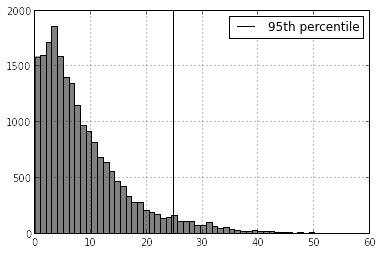

In [8]:
lossTaxa["Avg"].hist(bins=50,color='grey')
bline = plt.axvline(24.92,color='black',label="95th percentile")
plt.legend()

#plt.savefig("AvgLossTaxa_distribution.svg")

## Flag genes

In [9]:
lossTaxa["HGT_flag"] = lossTaxa["Avg"] >= 24.92
lossTaxa.head()

,InParanoid,InParanoidCore,OMA_Groups,OMA_Pairs,PANTHER8_LDO,RSD,EggNOG,Orthoinspector,Hieranoid_2,EnsemblCompara_v2,PANTHER8_all,Metaphors,PhylomeDB,Avg,HGT_flag
Q8TEA1,37,24,19,17,22,33,20,38,16,25,39,40,41,28.538462,True
A6NIH7,10,27,26,12,22,23,21,22,21,26,22,22,25,21.461538,False
Q96HJ5,1,1,1,0,1,1,1,1,5,4,16,5,5,2.166667,False
O94913,10,7,1,6,8,2,8,5,20,5,8,11,1,6.000000,False
P37837,18,25,29,26,4,12,22,15,25,14,15,17,15,18.230769,False


In [9]:
lossTaxa.to_csv("HGTFlag_HUMAN.csv")